In [0]:
import tensorflow as tf
from tensorflow import keras

In [2]:
!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [0]:
from IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

In [0]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [5]:
gz = keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

2816409600/2816407858 [==============================] - 145s 0us/step


In [0]:
FEATURES = 28

In [0]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

In [0]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

In [0]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


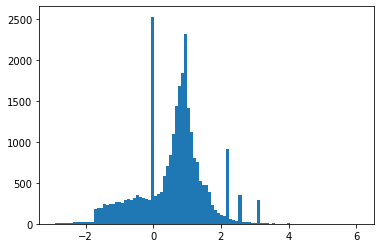

In [10]:
for features, label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins=101)

In [0]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [0]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [13]:
train_ds

<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

In [0]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

In [0]:
lr_schedule = keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=1,
    staircase=False
)

def get_optimizer():
  return keras.optimizers.Adam(lr_schedule)

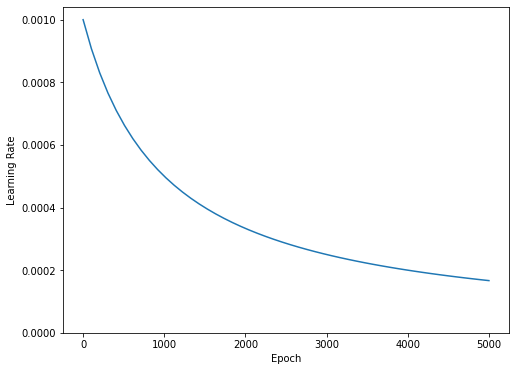

In [16]:
step = np.linspace(0, 100000)
lr = lr_schedule(step)
plt.figure(figsize=(8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0, max(plt.ylim())])
plt.xlabel("Epoch")
_ = plt.ylabel("Learning Rate")

In [0]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    keras.callbacks.TensorBoard(logdir/name)
  ]

In [0]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  keras.losses.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])
  model.summary()

  history = model.fit(
      train_ds,
      steps_per_epoch=STEPS_PER_EPOCH,
      epochs=max_epochs,
      validation_data=validate_ds,
      callbacks=get_callbacks(name),
      verbose=0)
  return history

In [0]:
tiny_model = keras.Sequential([
    keras.layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    keras.layers.Dense(1)
])

In [0]:
size_histories = {}

In [23]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4974,  binary_crossentropy:0.7602,  loss:0.7602,  val_accuracy:0.5160,  val_binary_crossentropy:0.7279,  val_loss:0.7279,  
....................................................................................................
Epoch: 100, accuracy:0.6041,  binary_crossentropy:0.6250,  loss:0.6250,  val_accuracy:0.5700,  val_binary_crossentropy:0.6323,  val_loss:0.6323,  
....................................................................................................
Epoch: 200, accuracy:0.62

(0.5, 0.7)

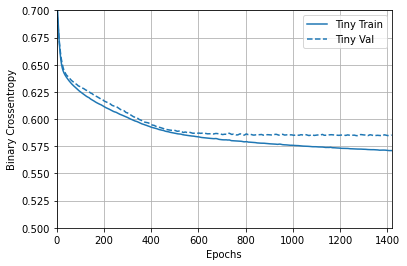

In [24]:
plotter = tfdocs.plots.HistoryPlotter(metric='binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

In [0]:
small_model = keras.Sequential([
    keras.layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    keras.layers.Dense(16, activation='elu'),
    keras.layers.Dense(1)
])

In [27]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4896,  binary_crossentropy:0.7287,  loss:0.7287,  val_accuracy:0.4790,  val_binary_crossentropy:0.7133,  val_loss:0.7133,  
....................................................................................................
Epoch: 100, accuracy:0.6246,  binary_crossentropy:0.6117,  loss:0.6117,  val_accuracy:0.6150,  val_binary_crossentropy:0.6124,  val_loss:0.

In [0]:
medium_model = keras.Sequential([
    keras.layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    keras.layers.Dense(64, activation='elu'),
    keras.layers.Dense(64, activation='elu'),
    keras.layers.Dense(1)
])

In [29]:
size_histories['Medium'] = compile_and_fit(medium_model, 'sizes/Medium')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                1856      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5004,  binary_crossentropy:0.6985,  loss:0.6985,  val_accuracy:0.5270,  val_binary_crossentropy:0.6745,  val_loss:0.6745,  
....................................................................................................
E

In [0]:
large_model = keras.Sequential([
    keras.layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    keras.layers.Dense(512, activation='elu'),
    keras.layers.Dense(512, activation='elu'),
    keras.layers.Dense(512, activation='elu'),
    keras.layers.Dense(1)
])

In [31]:
size_histories['Large'] = compile_and_fit(large_model, 'sizes/Large')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_13 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4984,  binary_crossentropy:0.7867,  loss:0.7867,  val_accuracy:0.5180,  val_binary_crossentr

Text(0.5, 0, 'Epochs [Log Scale]')

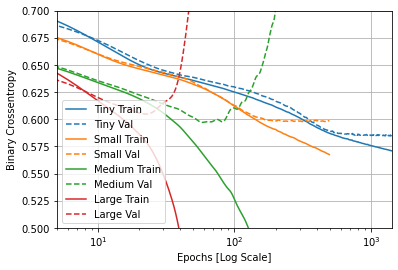

In [32]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel('Epochs [Log Scale]')

In [33]:
%tensorboard --logdir {logdir}/sizes

UsageError: Line magic function `%tensorboard` not found.


In [34]:
display.IFrame(
    src="https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97",
    width="100%", height="800px")

In [37]:
!tensorboard dev upload --logdir  {logdir}/sizes

2020-05-10 18:32:49.269500: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

/tmp/tmp61ho20l9/tensorboard_logs/sizes

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3

KeyboardInterrupt: ignored

In [0]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.rmtree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

In [0]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

In [45]:
l2_model = keras.Sequential([
    keras.layers.Dense(512, activation='elu',
                 kernel_regularizer=keras.regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    keras.layers.Dense(512, activation='elu',
                 kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dense(512, activation='elu',
                 kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dense(512, activation='elu',
                 kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dense(1)              
])

regularizer_histories['l2'] = compile_and_fit(l2_model, 'regularizers/l2')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_17 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_18 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5148,  binary_crossentropy:0.7705,  loss:2.2777,  val_accuracy:0.5390,  val_binary_crossentr

(0.5, 0.7)

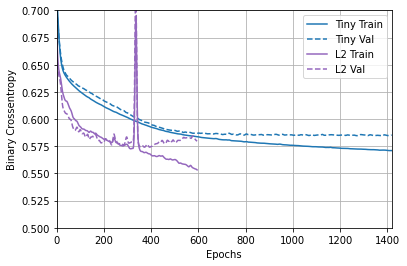

In [46]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [0]:
result = l2_model(features)
regularization = tf.add_n(l2_model.losses)

In [50]:
dropout_model = tf.keras.Sequential([
    keras.layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(512, activation='elu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(512, activation='elu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(512, activation='elu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1)
])
    
regularizer_histories['dropout'] = compile_and_fit(dropout_model, 'regularizers/dropout')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 512)              

(0.5, 0.7)

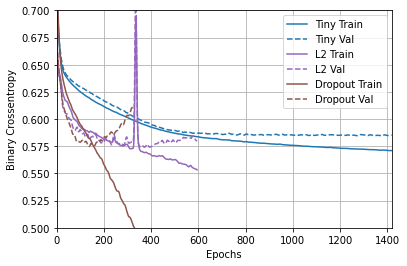

In [51]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [52]:
combined_model = keras.Sequential([
    keras.layers.Dense(512, activation='elu',
                 kernel_regularizer=keras.regularizers.l2(0.0001),
                 input_shape=(FEATURES,)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(512, activation='elu',
                 kernel_regularizer=keras.regularizers.l2(0.0001)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(512, activation='elu',
                 kernel_regularizer=keras.regularizers.l2(0.0001)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(512, activation='elu',
                 kernel_regularizer=keras.regularizers.l2(0.0001)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1)              
])

regularizer_histories['combined'] = compile_and_fit(combined_model, 'regularizers/combined')

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 512)              

(0.5, 0.7)

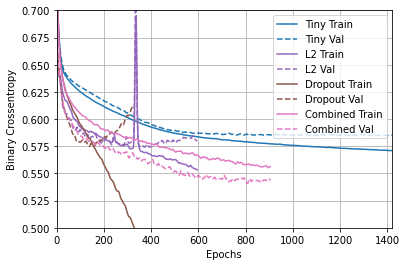

In [53]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [54]:
display.IFrame(
    src="https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97",
    width = "100%",
    height="800px")